In [3]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
from PIL import Image
from PIL import ImageFilter
#import tensorflow_datasets as tfds

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
    #"Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg16.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                            outputs[self.num_style_layers:])
    
        style_outputs = [gram_matrix(style_output)
                for style_output in style_outputs]
    
        content_dict = {content_name:value 
                for content_name, value 
                in zip(self.content_layers, content_outputs)}
    
        style_dict = {style_name:value
                for style_name, value
                in zip(self.style_layers, style_outputs)}
        return {'content':content_dict, 'style':style_dict}

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

# Create a simple function to display an image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

def sharpen_2(img):
    imageObject = tensor_to_image(img)

    sharpened1 = imageObject.filter(ImageFilter.SHARPEN)
    sharpened2 = sharpened1.filter(ImageFilter.SHARPEN)    

    sharpend1_array = tf.keras.preprocessing.image.img_to_array(sharpened1)/255

    max_dim = 512
    shape = tf.cast(tf.shape(sharpend1_array)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    sharpend1_tf = tf.image.resize(sharpend1_array, new_shape)
    sharpend1_tf = sharpend1_tf[tf.newaxis, :]

    return sharpend1_tf

def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

# we modified the gram matrix
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    # mean of sum_k F^l_{ik} F^l_{jk}, used in the tutorial
    # sum_k F^l_{ik} F^l_{jk} / (I J)
    mean_sum = result/(num_locations)
    # sum_k F^l_{ik} F^l_{jk}, used in the paper
    sum = result
    return result

def gaussian_blur(img, kernel_size=11, sigma=5):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]

    return tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')


def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)




In [171]:
class StyleTransfer:
    def __init__(self,content_image,style_image,content_layers,style_layers):
        super(StyleTransfer, self).__init__()
        self.content_image = tf.Variable(content_image,dtype=tf.float32)
        self.style_image = tf.Variable(style_image,dtype=tf.float32)
        self.extractor = StyleContentModel(style_layers, content_layers)
        self.origin_image = self.content_image
        self.style_targets = self.extractor(style_image)['style']
        self.content_targets = self.extractor(content_image)['content']
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)
        self.style_weight=1e-3
        self.content_weight=1e4
        self.variation_weight=30
        self.opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

    def total_loss(self,outputs, alpha = 10000, beta = 0.1,style_weight = None,
           content_weight = None, variation_weight = None):
        if style_weight == None:
            style_weight = self.style_weight
        if content_weight == None:
            content_weight = self.content_weight
        if variation_weight == None:
            variation_weight = self.variation_weight
        self.num_style_layers = self.num_style_layers
        self.num_content_layers = self.num_content_layers
        style_targets = self.style_targets
        content_targets = self.content_targets
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_sum((style_outputs[name]-style_targets[name])**2) 
                for name in style_outputs.keys()])
        style_loss *= style_weight / num_style_layers
        content_loss = tf.add_n([tf.reduce_sum((content_outputs[name]-content_targets[name])**2) 
                        for name in content_outputs.keys()])
        content_loss *= content_weight / num_content_layers
        
        #variation_loss = tf.image.total_variation(output)
        #variation_loss *= variation_weight
        #Todo: need some clarification on variation loss calculate
        variation_loss = 0
        
        loss = beta*style_loss + alpha*content_loss + variation_loss
        return loss
  
    @tf.function()
    def train_step(self,alpha=10000,beta=0.1,style_weight = None,
                   content_weight = None, variation_weight = None):
        image = self.origin_image
        opt = self.opt
        with tf.GradientTape() as tape:
            outputs = self.extractor(image)
            # alpha = 10000, beta = 0.1 for content ini
            loss = self.total_loss(outputs, alpha=alpha, beta=beta,
                                   style_weight = None, content_weight = None, 
                                   variation_weight = None)
        
        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image = image.assign(clip_0_1(image))
        self.orgin_image = image
  
    def train_whole(self,epochs = 50,steps_per_epoch =
        50,blur=False,sharpen=False,blackwhite=False,alpha=10000,beta=0.1,
        style_weight = None,content_weight = None, variation_weight = None):
        image = self.origin_image
        print(type(image))
        start = time.time()
        step = 0
        for n in range(epochs):
            for m in range(steps_per_epoch):
                step += 1
                self.train_step(alpha=alpha, beta = beta)
                print(".", end='')
            display.clear_output(wait=True)
                # adding a blur process after each epoch, you can comment it out if needed
            if blur:
                image.assign(gaussian_blur(image, kernel_size= 2.5, sigma=5))
            # to sharpen the output image
            if sharpen:
                image.assign(sharpen_2(image))
            # force to be black and white
            if blackwhite:
                image.assign(tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image)))
            display.display(tensor_to_image(image))
            print("Train step: {}".format(step))
        
        end = time.time()
        print("Total time: {:.1f}".format(end-start))
  
    def update_extractor(self, style_layers,content_layers):
        self.extractor = StyleContentModel(style_layers, content_layers)
  
    def update_content_style(self, content_image = None,
        style_image = None):
        if content_image == None:
            content_image = self.content_image
        if style_image == None:
            style_image = self.style_image
        self.content_image = content_image
        self.style_image = style_image


In [168]:
# select block4 conv 2 as content layer
content_layers = ['block5_conv2'] 

# select the following layers as style layer 
style_layers = ['block1_conv1',
          'block2_conv1',
          'block3_conv1', 
          'block4_conv1', 
          'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [169]:
style_changer = StyleTransfer(content_image,style_image,content_layers,style_layers)

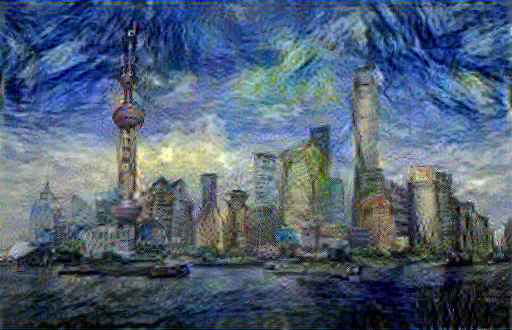

Train step: 2500
Total time: 180.7


In [170]:
# you can pass in epochs, steps_per_epoch, and whether to blur, sharpen or make the image black and white here
# you can also change alpha and beta value
# for detail refer to the class
style_changer.train_whole(epochs = 50,steps_per_epoch =50,
                          blur=False,sharpen=False,blackwhite=False,
                          alpha=10000,beta=0.1)